In [2]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, LineSearches, LsqFit, JuMP, DSP, DataFrames, CSV, StatsBase, LinearRegression, LinearAlgebra, CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/Documents/SSC/recs_june_2022"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

for f = 1:length(files)
    filename = files[f]

    global Data = readCSF(filename)
    # sf = Data["samplingfr"]
    sf = 0.1
    println("File $f out of $(length(files))\n")

    global T = Data["T"]
    global rec_dur_s = Data["rec_dur_s"]
    global start_time = Data["start_time"]
    global end_time = Data["end_time"]
    global infusion_start_frame = Data["infusion_start_frame"]
    global infusion_end_frame = Data["infusion_end_frame"]
    global plateau_start = Data["plateau_start"]
    global plateau_end = Data["plateau_end"]
    global ICP = Data["ICP"]
    global E = Data["E"]
    global P_p = Data["P_p"]
    global P_b = Data["P_b"]
    global I_b = Data["I_b"]
    global I_inf = Data["I_inf"]
    global AMP = Data["AMP"]
    global P_0 = Data["P_0"]

    length(ICP) < infusion_end_frame ? Pm = ICP[infusion_start_frame:end] : Pm = ICP[infusion_start_frame:infusion_end_frame]

    bayes_res = CSV.File("/Users/jjc/Documents/SSC/recs_june_2022/results_raw_jjc.csv")
    icmp_res = CSV.File("/Users/jjc/Documents/SSC/recs_june_2022/results_raw_icm.csv")

    global R_icm = icmp_res["Rcsf"]
    global R_bayes = bayes_res["Rcsf"]

    global Ib_icm = icmp_res["Ib"]
    global Ib_bayes = bayes_res["Ib"]

    global P0_icm = icmp_res["P0"]
    global P0_bayes = bayes_res["P0"]

    global E_icm = icmp_res["E"]
    global E_bayes = bayes_res["E"]

    numsamples = length(ICP)
    infusion_end_frame > numsamples ? (global infusion_end_frame = numsamples) : 0
    P_m = zeros(numsamples)
    P_m .+= P_b

    ICPm = zeros(infusion_end_frame - infusion_start_frame)

    function getPm(I_b, E, P_0, ICP)

        err = 0
        P_model = zeros(numsamples)
        for i = infusion_start_frame:infusion_end_frame
            tᵢ = (i - infusion_start_frame) / 6
            It = I_b + I_inf
            ΔP = P_b - P_0
            y = It * ΔP / (I_b + (I_inf * exp(-E * It * tᵢ))) + P_0
            P_model[i] = y
            err += (ICP[i] - P_model[i])^2
        end

        global goodness_of_fit = 100 * (sqrt(err) / length(P_model) / abs(mean(P_model)))

        ICPm = P_model[infusion_start_frame:infusion_end_frame]
        P_m[infusion_start_frame:infusion_end_frame] = ICPm
        P_m[infusion_end_frame+1:end] .= ICPm[end]
        return P_m, goodness_of_fit
    end


    colorscheme = "dark"

    if colorscheme == "light"
        fgcolor = :black
        bgcolor = :white
        icpcol = :cadetblue
        bayescol = :red
        icmcol = :darkorchid4
        infcol = :gray95

    else
        fgcolor = :white
        bgcolor = RGB(0.13, 0.14, 0.14)
        icpcol = :cadetblue
        bayescol = :violet
        icmcol = :orange
        infcol = RGB(0.15, 0.17, 0.17)
    end


    framespan = plateau_end

    tix = [0:30:framespan;]
    # h1 = vline([infusion_start_frame], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor= inflinecol, alpha=0.5, linewidth=1, label="Start of infusion")
    # vline!([infusion_end_frame], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor= inflinecol, alpha=0.5, linewidth=1, label="End of infusion")
    # vline!([plateau_start], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor=:mint, alpha=0.5, linewidth=1, label="Start of plateau")
    # hline!([P_p], linecolor=:coral2, label="Pₚ", linewidth=0.5, alpha=0.5)

    h1 = vspan([infusion_start_frame, infusion_end_frame], color=infcol, legend=:outertopright, label="Infusion period", linecolor=:transparent)

    nr = f
    plot!(ICP, linecolor=icpcol, linewidth=3, label="ICP", alpha=0.7)
    Pm, gof_bayes = getPm(Ib_bayes[nr], E_bayes[nr], P0_bayes[nr], ICP)
    plot!(Pm, linecolor=bayescol, linewidth=2, linestyle=:dash, xlims=[1, framespan], ylims=[-10, 50],
        xlabel="Time [min]", ylabel="ICP [mmHg]", xticks=(tix, round.(tix ./ 6, digits=2)),
        label="BayesOpt", grid=false, titlefontsize=8, titlealign=:left, background=bgcolor, foreground_color_subplot=fgcolor)

    Pm, gof_icm = getPm(Ib_icm[nr], E_icm[nr], P0_icm[nr], ICP)
    plot!(Pm, linecolor=icmcol, linewidth=2, linestyle=:dash, xlims=[1, framespan], ylims=[-10, 50],
        xlabel="Time [min]", ylabel="ICP [mmHg]", xticks=(tix, round.(tix ./ 6, digits=2)),
        label="ICM+", grid=false, titlefontsize=8, titlealign=:left, background=bgcolor, foreground_color_subplot=fgcolor)

    txtcontent = ("Bayes:" * "\nIₐ = $(round(Ib_bayes[nr], digits=2)) [mL/min]\n" * "E = $(round(E_bayes[nr],digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P0_bayes[nr],digits=2)) [mmHg]\n" * "Rₒ = $(round(R_bayes[nr],digits=2))  [mmHg/mL/min]\n" * "err = $(round(gof_bayes, digits=3))\n" * "\nICM+:" * "\nIₐ = $(round(Ib_icm[nr], digits=2)) [mL/min]\n" * "E = $(round(E_icm[nr],digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P0_icm[nr],digits=2)) [mmHg]\n" * "Rₒ = $(round(R_icm[nr],digits=2))  [mmHg/mL/min]\n" * "err = $(round(gof_icm, digits=3))\n")

    # txtcontent = ("ICM+:" * "\nIₐ = $(round(Ib_icm[nr], digits=2)) [mL/min]\n" * "E = $(round(E_icm[nr],digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P0_icm[nr],digits=2)) [mmHg]\n" * "Rₒ = $(round(R_icm[nr],digits=2))  [mmHg/mL/min]\n" * "err = $(round(gof_icm, digits=3))\n")

    annotate!(framespan * 1.1, 10, text(txtcontent, fgcolor, :left, 7))

    P = ICP[infusion_start_frame:infusion_end_frame]
    dpress = zeros(length(P))
    dvol = zeros(length(P))
    dpress[1] = 1
    for i = 2:length(P)
        dvol[i] = dvol[i-1] + (I_inf + Ib_bayes[nr] - (P[i] - P0_bayes[nr]) / R_bayes[nr]) * 1 / 6
        dpress[i] = (P[i] - P0_bayes[nr]) / (P_b - P0_bayes[nr])
    end

    try
        global coefval = CurveFit.curve_fit(ExpFit, dvol, dpress)
    catch
        continue
    end
    fitted_curve = coefval.(dvol)

    h2 = plot(dvol, dpress, seriestype=:scatter, markercolor=:cadetblue, markersize=6, markerstrokewidth=.5, markerstrokecolor=infcol, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=RGB(0.13, 0.14, 0.14), size=(700, 800), xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=false)

    plot!(dvol, fitted_curve, lw=3, linecolor=:orange, linestyle=:dash, yaxis=:log)

    plot(h1, h2, layout=(2, 1))

    # plot(h1)
    savefig("/Users/jjc/Documents/SSC/recs_june_2022/combined/" * filename[length(datapath)+2:end-5] * "combined.pdf")
    # println(filename[length(datapath)+2:end-5] * " " * "$(round(I_b,digits=3))" * " " * "$(E_bayes[nr])" * " " * "$(P0_bayes[nr])" * "\n\n")
end

File 1 out of 96

File 2 out of 96

File 3 out of 96

File 4 out of 96

File 5 out of 96

File 6 out of 96

File 7 out of 96

File 8 out of 96

File 9 out of 96

File 10 out of 96

File 11 out of 96

File 12 out of 96

File 13 out of 96

File 14 out of 96

File 15 out of 96

File 16 out of 96

File 17 out of 96

File 18 out of 96

File 19 out of 96

File 20 out of 96

File 21 out of 96

File 22 out of 96

File 23 out of 96

File 24 out of 96

File 25 out of 96

File 26 out of 96

File 27 out of 96

File 28 out of 96

File 29 out of 96

File 30 out of 96

File 31 out of 96

File 32 out of 96

File 33 out of 96

File 34 out of 96

File 35 out of 96

File 36 out of 96

File 37 out of 96

File 38 out of 96

File 39 out of 96

File 40 out of 96

File 41 out of 96

File 42 out of 96

File 43 out of 96

File 44 out of 96

File 45 out of 96

File 46 out of 96

File 47 out of 96

File 48 out of 96

File 49 out of 96

File 50 out of 96

File 51 out of 96

File 52 out of 96

File 53 out of 96

Fi

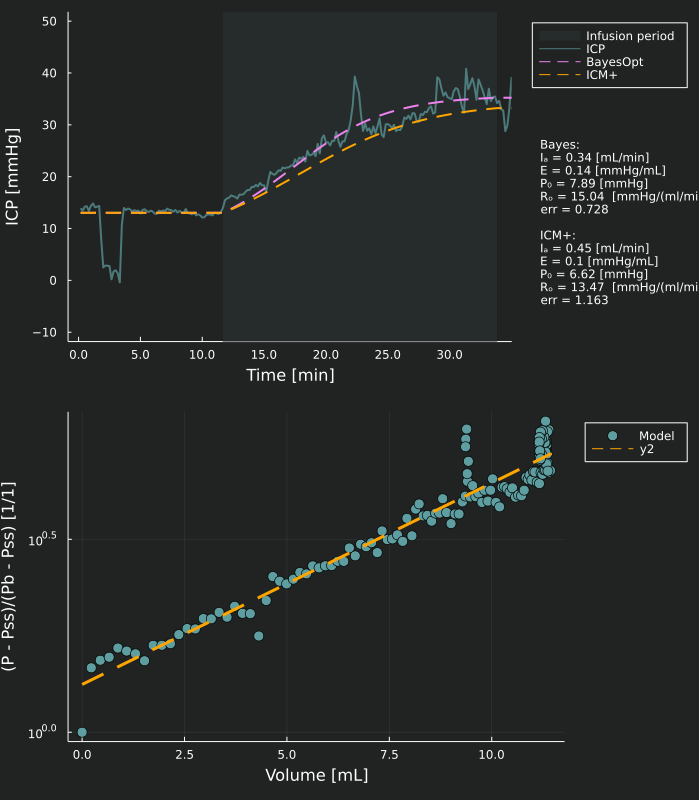

In [3]:
numsamples = length(ICP)
infusion_end_frame > numsamples ? (global infusion_end_frame = numsamples) : 0
P_m = zeros(numsamples)
P_m .+= P_b

ICPm = zeros(infusion_end_frame - infusion_start_frame)
function getPm(I_b, E, P_0, ICP)

    err = 0
    P_model = zeros(numsamples)
    for i = infusion_start_frame:infusion_end_frame
        tᵢ = (i - infusion_start_frame) / 6
        It = I_b + I_inf
        ΔP = P_b - P_0
        y = It * ΔP / (I_b + (I_inf * exp(-E * It * tᵢ))) + P_0
        P_model[i] = y
        err += (ICP[i] - P_model[i])^2
    end

    global goodness_of_fit = 100 * (sqrt(err) / length(P_model) / abs(mean(P_model)))

    ICPm = P_model[infusion_start_frame:infusion_end_frame]
    P_m[infusion_start_frame:infusion_end_frame] = ICPm
    P_m[infusion_end_frame+1:end] .= ICPm[end]
    return P_m, goodness_of_fit
end

numsamples = length(ICP)
f = 96
tix = [0:30:plateau_end;]

colorscheme = "dark"

if colorscheme == "light"
    fgcolor = :black
    bgcolor = :white
    icpcol = :cadetblue
    bayescol = :red
    icmcol = :darkorchid4
    infcol = :gray95

else
    fgcolor = :white
    bgcolor = RGB(0.13, 0.14, 0.14)
    icpcol = :cadetblue
    bayescol = :violet
    icmcol = :orange
    infcol = :gray15
end

# h1 = vline([infusion_start_frame], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor=:white, alpha=0.5, linewidth=1, label="Start of infusion")
# vline!([infusion_end_frame], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor=:white, alpha=0.5, linewidth=1, label="End of infusion")
# vline!([plateau_start], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor=:mint, alpha=0.5, linewidth=1, label="Start of plateau")
# hline!([P_p], linecolor=:coral2, label="Pₚ", linewidth=0.5, alpha=0.5)

h1 = vspan([infusion_start_frame,infusion_end_frame], color=RGB(0.15, 0.17, 0.17), legend=:outertopright, label="Infusion period")

nr = f
plot!(ICP, linecolor=:cadetblue, linewidth=2, label="ICP", alpha=0.7)
Pm, gof_bayes = getPm(Ib_bayes[nr], E_bayes[nr], P0_bayes[nr], ICP)
plot!(Pm, linecolor=:violet, linewidth=2, linestyle=:dash, xlims=[1, plateau_end], ylims=[-10, 50],
    xlabel="Time [min]", ylabel="ICP [mmHg]", xticks=(tix, round.(tix ./ 6, digits=2)),
    label="BayesOpt", grid=false, titlefontsize=8, titlealign=:left, background=RGB(0.13, 0.14, 0.14), foreground_color_subplot=:white)

Pm, gof_icm = getPm(Ib_icm[nr], E_icm[nr], P0_icm[nr], ICP)
plot!(Pm, linecolor=:orange, linewidth=2, linestyle=:dash, xlims=[1, plateau_end], ylims=[-10, 50],
    xlabel="Time [min]", ylabel="ICP [mmHg]", xticks=(tix, round.(tix ./ 6, digits=2)),
    label="ICM+", grid=false, titlefontsize=8, titlealign=:left, background=RGB(0.13, 0.14, 0.14), foreground_color_subplot=:white)

txtcontent = ("Bayes:" * "\nIₐ = $(round(Ib_bayes[nr], digits=2)) [mL/min]\n" * "E = $(round(E_bayes[nr],digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P0_bayes[nr],digits=2)) [mmHg]\n" * "Rₒ = $(round(R_bayes[nr],digits=2))  [mmHg/(ml/min)]\n" * "err = $(round(gof_bayes, digits=3))\n" * "\nICM+:" * "\nIₐ = $(round(Ib_icm[nr], digits=2)) [mL/min]\n" * "E = $(round(E_icm[nr],digits=2)) [mmHg/mL]\n" * "P₀ = $(round(P0_icm[nr],digits=2)) [mmHg]\n" * "Rₒ = $(round(R_icm[nr],digits=2))  [mmHg/(ml/min)]\n" * "err = $(round(gof_icm, digits=3))\n")

annotate!(plateau_end * 1.1, 10, text(txtcontent, :white, :left, 8))

P = ICP[infusion_start_frame:infusion_end_frame]
dvol = zeros(length(P))
dpress = zeros(length(P))
dpress[1] = 1
for i = 2:length(P)
    dvol[i] = dvol[i - 1] + (I_inf + Ib_bayes[nr] - (P[i] - P0_bayes[nr]) / R_bayes[nr]) * 1 / 6
    dpress[i] = (P[i] - P0_bayes[nr]) / (P_b - P0_bayes[nr])
end


coefval = CurveFit.curve_fit(ExpFit, dvol, dpress)
fitted_curve = coefval.(dvol)

h2 = plot(dvol, dpress, seriestype=:scatter, markercolor=:cadetblue, markersize=6, markerstrokewidth=.5, markerstrokecolor=:black, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=RGB(0.13, 0.14, 0.14), size=(700, 800), xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=:outertopright)

plot!(dvol,fitted_curve, lw=3, linecolor=:orange, linestyle=:dash, yaxis=:log)

plot(h1, h2, layout = (2,1))


In [133]:
using HDBSCAN, Clustering

X = hcat(dvol,log.(dpress))'

min_cluster_size=5
result = hdbscan(X; min_cluster_size)

probabilities(result)
exemplars(result)       # Computed at first call, this takes long time
outlier_scores(result)
raw_data(result) == X

res = result.assignments

plot(dvol[res .== 0], (dpress[res .== 0]), seriestype=:scatter, markerstrokewidth=.5, markerstrokecolor=:black, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=RGB(0.13, 0.14, 0.14), xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=:outertopright)
for i = 1:maximum(res)
    plot!(dvol[res .== i], (dpress[res .== i]), seriestype=:scatter, markerstrokewidth=.5, markerstrokecolor=:black, linewidth=1, label="Model", grid=true, titlefontsize=8, titlealign=:left, background=RGB(0.13, 0.14, 0.14), xlabel="Volume [mL]", ylabel="(P - Pss)/(Pb - Pss) [1/1]", legend=:outertopright)
end

volRes = dvol[res .== 0]
pressRes = dpress[res .== 0]
coefval = CurveFit.curve_fit(ExpFit, volRes, pressRes)
fitted_curve = coefval.(volRes)

Ehat = pressRes ./ (volRes .* (P[res .== 0] .- P_0))

plot!(volRes,fitted_curve, lw=3, linecolor=:orange, linestyle=:dash, yaxis=:log, legend=:outertopright)
println(round(mean(Ehat[2:end]), digits=3))


hdbs = PyObject <module 'hdbscan' from '/Users/jjc/.julia/conda/3/lib/python3.9/site-packages/hdbscan/__init__.py'>
0.058
